# Esame di Probabilità e Statistica 

##  Carlo Bruno Torreggiani

- Analisi qualitativa della popolazione contenuta nei comuni italiani.
- andamento per ogni comune (tasso di crescita e possibili comuni morenti)
- guardare se torino si popola e poi provare a fare una mappa fikissima
- guardare la correlazione tra diversi anni del tasso di popolamento

In [19]:
%matplotlib inline
import pandas as pd
import numpy as np
import scipy.stats 
import scipy
import seaborn as sns
import matplotlib.pylab as plt
from PIL import Image
import os
import re

In [3]:
# importo i dati ############################################################################à
inData_Residenti = pd.read_excel("Residenti.xlsx", header = 1)
inData_Iscritti = pd.read_excel("iscritti.xlsx", header = 1)
inData_Cancellati = pd.read_excel("Cancellati.xlsx", header = 1)


# Rimuovo spazi dai nomi delle colonne per coerenza
inData_Residenti.columns = inData_Residenti.columns.str.strip()
inData_Iscritti.columns = inData_Iscritti.columns.str.strip()
inData_Cancellati.columns = inData_Cancellati.columns.str.strip()


In [4]:
# tolgo l'ultima riga perché risulta vuota
inData_Cancellati = inData_Cancellati.drop(inData_Cancellati.index[-1])
inData_Residenti = inData_Residenti.drop(inData_Residenti.index[-1])
inData_Iscritti = inData_Iscritti.drop(inData_Iscritti.index[-1])

## Analisi qualitativa della popolazione contenuta nei comuni italiani

Voglio studiare qualitativamente l'andamento della popolazione nei vari comuni italiani. Per farlo, mi interesso di come varia il numero dei comuni per numero di abitanti, osservando anche come varia nel corso degli anni. Inoltre, mi sono chiesto se la popolazione è contenuta nella maggior parte in comuni grandi o piccoli, studiando il caso della popolazione del 2019.

#### Studio del numero di comuni divisi per numero di abitanti

In [5]:
# Creo una tabella che mi mostra i numeri di comuni divisi per numero di abitanti (2001) 

# Creo intervalli (bin) da 0 a 20000 con passo 1000
bins = list(range(0, 21000, 1000))

# Etichette per gli intervalli
labels = [f'{bins[i]}-{bins[i+1]-1}' for i in range(len(bins)-1)]

# Assegno a ogni comune l'intervallo di appartenenza
intervalli = pd.cut(inData_Residenti["2001"], bins=bins, labels=labels, right=False)

# Calcolo il numero di comuni per ogni intervallo senza somma cumulativa
conteggio_per_intervallo = intervalli.value_counts().sort_index()

# Creo la tabella finale
tabella = pd.DataFrame({'Intervallo popolazione': conteggio_per_intervallo.index,
                        'Numero comuni nel 2001': conteggio_per_intervallo.values})

print(tabella)

   Intervallo popolazione  Numero comuni nel 2001
0                   0-999                    1394
1               1000-1999                    1027
2               2000-2999                     632
3               3000-3999                     428
4               4000-4999                     343
5               5000-5999                     234
6               6000-6999                     179
7               7000-7999                     163
8               8000-8999                     116
9               9000-9999                      84
10            10000-10999                      80
11            11000-11999                      67
12            12000-12999                      54
13            13000-13999                      46
14            14000-14999                      36
15            15000-15999                      37
16            16000-16999                      27
17            17000-17999                      21
18            18000-18999                      19


In [12]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd

inData_Residenti_filtrato = inData_Residenti[inData_Residenti['2001'] < 100000]
anni = [col for col in inData_Residenti_filtrato.columns if col != 'Territorio']

fig, ax = plt.subplots(figsize=(10,6))

# Impostazione limiti fissi prima dell'animazione
ax.set_xlim(0, 100000)
ax.set_ylim(0, 2000)
ax.grid(True)

def update(frame):
    ax.cla()  # pulisce la figura
    anno = anni[frame]
    data = pd.to_numeric(inData_Residenti_filtrato[anno], errors='coerce').dropna()
    ax.hist(data, bins=100, color='skyblue')
    ax.set_title(f'Distribuzione popolazione comuni - {anno}')
    ax.set_xlabel('Popolazione')
    ax.set_ylabel('Numero di comuni')
    # Riassegno limiti fissi e disabilito autoscale
    ax.set_xlim(0, 100000)
    ax.set_ylim(0, 2000)
    ax.autoscale(enable=False)
    ax.grid(True)

ani = animation.FuncAnimation(fig, update, frames=len(anni), repeat=True)
ani.save('popolazione_comuni.gif', writer='pillow', fps=1)
plt.close(fig)


![Popolazione Comuni](popolazione_comuni.gif)


Si può osservare che il numero di comuni con poche persone è nettamente maggiore di molte con poche persone, con un andamento che decresce in modo monotono. Tale andamento non varia significativamente nel corso degli anni.

#### Analizzo i dati del 2019 per studiare dove è contenuta la maggior parte della popolazione

In [13]:
# Costruisco una tabella che mi mostra la percentuale di popolazione nei comuni divisi per numero di abitanti e la percentuale cumulata

inData_Residenti.columns = inData_Residenti.columns.str.strip()
residenti = inData_Residenti.loc[inData_Residenti['Territorio'] != 'Italia'].copy()
ultimo_anno = [col for col in residenti.columns if str(col).isdigit()][-1]

residenti.loc[:, ultimo_anno] = pd.to_numeric(residenti[ultimo_anno], errors='coerce')

bin_edges = list(range(0, int(residenti[ultimo_anno].max()) + 10000, 5000))
labels = [f"{bin_edges[i]}-{bin_edges[i+1]-1}" for i in range(len(bin_edges)-1)]
residenti.loc[:, 'Fascia'] = pd.cut(residenti[ultimo_anno], bins=bin_edges, labels=labels, right=False)

summary = residenti.groupby('Fascia', observed=True)[ultimo_anno].sum()
total = residenti[ultimo_anno].sum()
percent = summary / total * 100

tabella = pd.DataFrame({
    'Fascia abitanti': percent.index,
    'Percentuale popolazione': percent.values
})
filtered_tabella = tabella[tabella['Percentuale popolazione'] > 0].reset_index(drop=True)

# Calcola percentuale cumulativa
filtered_tabella['Percentuale cumulativa'] = filtered_tabella['Percentuale popolazione'].cumsum()

print(filtered_tabella)


    Fascia abitanti  Percentuale popolazione  Percentuale cumulativa
0            0-4999                16.643993               16.643993
1         5000-9999                14.926099               31.570092
2       10000-14999                 9.695086               41.265179
3       15000-19999                 6.874977               48.140156
4       20000-24999                 4.092129               52.232285
5       25000-29999                 2.983930               55.216215
6       30000-34999                 2.520939               57.737155
7       35000-39999                 2.791471               60.528626
8       40000-44999                 1.743310               62.271936
9       45000-49999                 2.562489               64.834425
10      50000-54999                 1.476690               66.311115
11      55000-59999                 0.890069               67.201184
12      60000-64999                 0.788932               67.990115
13      65000-69999               

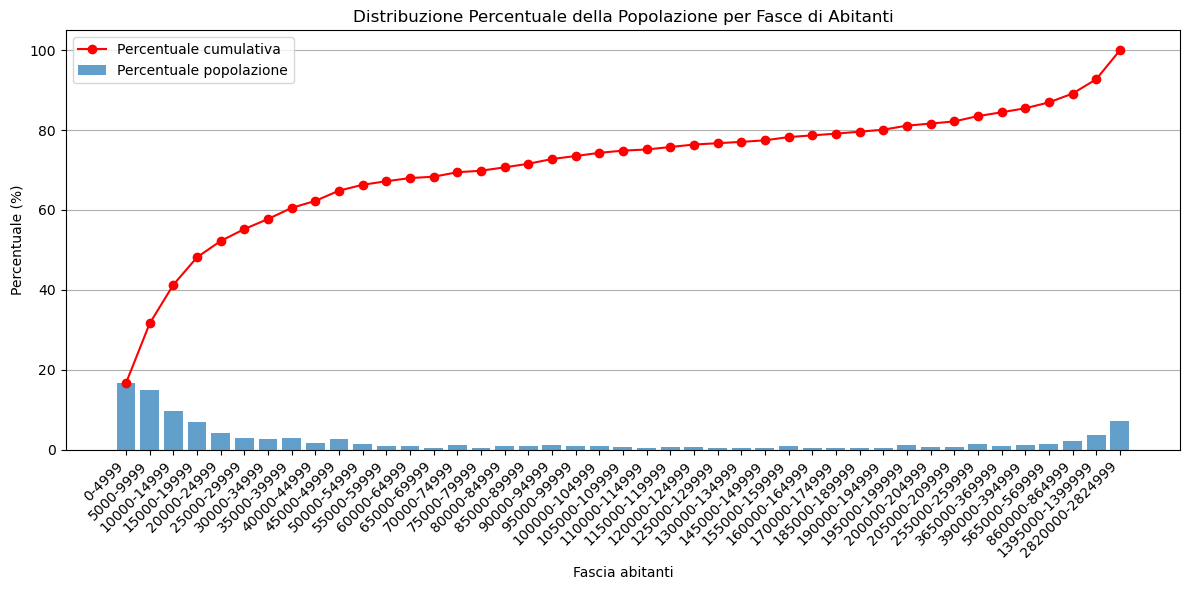

In [14]:
# Costruisco un istogramma che mi mostra la percentuale di popolazione nei comuni

plt.figure(figsize=(12, 6))

# Bar plot per percentuale popolazione
plt.bar(filtered_tabella['Fascia abitanti'], filtered_tabella['Percentuale popolazione'], alpha=0.7, label='Percentuale popolazione')

# Line plot per percentuale cumulativa
plt.plot(filtered_tabella['Fascia abitanti'], filtered_tabella['Percentuale cumulativa'], color='red', marker='o', label='Percentuale cumulativa')

plt.xticks(rotation=45, ha='right')
plt.xlabel('Fascia abitanti')
plt.ylabel('Percentuale (%)')
plt.title('Distribuzione Percentuale della Popolazione per Fasce di Abitanti')
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()


Si nota che la maggior parte della popolazione (50%) è contenuta nella parte di comuni che hanno meno di 20.000 abitanti. Un contributo considerevole è anche dato dalle poche grandi città. La curva cumulativa resta pressoché piatta quando si considerano i comuni medio popolosi.

## Andamento della decrescita dei comuni italiani 

In [16]:

# Escludo la riga 'Italia'
inData_Residenti_NoTot = inData_Residenti[inData_Residenti['Territorio'] != 'Italia'].copy()
inData_Iscritti_NoTot = inData_Iscritti[inData_Iscritti['Territorio'] != 'Italia'].copy()
inData_Cancellati_NoTot = inData_Cancellati[inData_Cancellati['Territorio'] != 'Italia'].copy()

# Ottengo la lista degli anni (colonne numeriche)
anni = [col for col in inData_Residenti_NoTot.columns if str(col).isdigit()]

# Converto le colonne degli anni in numerico, evitando warning con .loc
for df in [inData_Residenti_NoTot, inData_Iscritti_NoTot, inData_Cancellati_NoTot]:
    for anno in anni:
        df.loc[:, anno] = pd.to_numeric(df[anno], errors='coerce')

# Calcolo saldo migratorio netto (iscritti - cancellati)
saldo = inData_Iscritti_NoTot.set_index('Territorio')[anni] - inData_Cancellati_NoTot.set_index('Territorio')[anni]

# Popolazione residente anno precedente (shiftata)
popolazione = inData_Residenti_NoTot.set_index('Territorio')[anni]
popolazione_shifted = popolazione.shift(axis=1)

# Sostituisco 0 con NaN nel denominatore per evitare divisione per zero
denominator = popolazione_shifted.values
denominator_safe = np.where(denominator == 0, np.nan, denominator)

# Calcolo tasso crescita netto percentuale evitando errori di divisione
with np.errstate(divide='ignore', invalid='ignore'):
    tasso_crescita_netto = saldo.values / denominator_safe
    tasso_crescita_netto = tasso_crescita_netto * 100

tasso_crescita_netto = pd.DataFrame(tasso_crescita_netto, index=saldo.index, columns=saldo.columns)





In [17]:
#provincia_torino_residenti = inData_Residenti_NoTot.iloc[:312]  # prende le prime 312 righe
#provincia_torino_iscritti = inData_Iscritti_NoTot.iloc[:312]  # prende le prime 312 righe
#provincia_torino_cancellati = inData_Cancellati_NoTot.iloc[:312]  # prende le prime 312 righe

In [17]:

cartella_output = os.path.join(os.getcwd(), 'gif')
os.makedirs(cartella_output, exist_ok=True)

# Lista anni escludendo 2001 e 2019
anni = [col for col in inData_Residenti_NoTot.columns if str(col).isdigit() and col not in ['2019', '2001']]

# Calcolo il limite massimo y per uniformare gli assi
max_y = 0
for anno_riferimento in anni:
    popolazione_anno = inData_Residenti_NoTot.set_index('Territorio')[anno_riferimento].astype(float)
    tasso_crescita_anno = tasso_crescita_netto[anno_riferimento]
    df = pd.DataFrame({
        'popolazione': popolazione_anno,
        'tasso_crescita': tasso_crescita_anno
    })
    df_small = df[df['popolazione'] < 50000].copy()
    bins = np.arange(0, 50000 + 1000, 1000)
    df_small['pop_bin'] = pd.cut(df_small['popolazione'], bins=bins, right=False)
    df_small['crescita_cat'] = np.where(df_small['tasso_crescita'] >= 0, 'Positivo', 'Negativo')
    count_df = df_small.groupby(['pop_bin', 'crescita_cat'], observed=True).size().unstack(fill_value=0)
    max_y = max(max_y, count_df.values.max())

for anno_riferimento in anni:
    popolazione_anno = inData_Residenti_NoTot.set_index('Territorio')[anno_riferimento].astype(float)
    tasso_crescita_anno = tasso_crescita_netto[anno_riferimento]
    df = pd.DataFrame({
        'popolazione': popolazione_anno,
        'tasso_crescita': tasso_crescita_anno
    })
    
    df_small = df[df['popolazione'] < 50000].copy()
    bins = np.arange(0, 50000 + 1000, 1000)
    labels = [f'{int(bins[i])}-{int(bins[i+1])-1}' for i in range(len(bins)-1)]
    df_small['pop_bin'] = pd.cut(df_small['popolazione'], bins=bins, labels=labels, right=False)
    df_small['crescita_cat'] = np.where(df_small['tasso_crescita'] >= 0, 'Positivo', 'Negativo')
    count_df = df_small.groupby(['pop_bin', 'crescita_cat'], observed=True).size().unstack(fill_value=0)
    
    ax = count_df.plot(kind='bar', stacked=True, figsize=(14,7), color=['crimson', 'seagreen'])
    ax.set_xlabel('Fasce di popolazione comunale (abitanti)')
    ax.set_ylabel('Numero di comuni')
    ax.set_title(f'Tasso di crescita positivo/negativo per fasce popolazione\n(Comuni < 50.000 abitanti - Anno {anno_riferimento})')
    
    # Imposta etichette asse X con margini per evitare taglio
    ax.set_xticks(range(len(count_df.index)))
    ax.set_xticklabels(count_df.index, rotation=45, ha='right')
    ax.margins(x=0.01)
    
    plt.legend(title='Tasso di crescita')
    plt.grid(axis='y')
    ax.set_ylim(0, max_y * 1.9)  # 10% margine y sopra massimo
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.30, right=0.98, left=0.07, top=0.93)

    
    nome_file = f'{cartella_output}/istogramma_{anno_riferimento}.png'
    plt.savefig(nome_file)
    plt.close()


In [24]:


# Cartella 'gif' dentro la cartella di lavoro corrente
cartella = os.path.join(os.getcwd(), 'gif')

file_list = os.listdir(cartella)

def estrai_anno(nome_file):
    match = re.search(r'(\d{4})', nome_file)
    return int(match.group(1)) if match else 0

file_list_png = sorted(
    [f for f in file_list if f.endswith('.png') and '2019' not in f],
    key=estrai_anno
)

frames = [Image.open(os.path.join(cartella, fname)) for fname in file_list_png]

# Salva la GIF nella cartella di lavoro corrente (non dentro gif)
output_gif = os.path.join(os.getcwd(), 'istogrammi_animati.gif')

frames[0].save(
    output_gif,
    save_all=True,
    append_images=frames[1:],
    duration=1000,   # durata per frame in millisecondi
    loop=0
)



![Animazione istogrammi](istogrammi_animati.gif)


In [25]:

# Lista anni dal 2002 in poi (escludi anni prima di 2002 e il 2019)
anni = [col for col in inData_Residenti_NoTot.columns if str(col).isdigit() and int(col) >= 2002 and col != '2019']

# Definisci fasce di popolazione da 0 a 10000 con step 1000
bins = np.arange(0, 10000 + 1000, 1000)
labels = [f'{bins[i]}-{bins[i+1]-1}' for i in range(len(bins)-1)]

# DataFrame per i risultati (anni come indice, fasce come colonne)
decrescita_time = pd.DataFrame(index=anni, columns=labels)

for anno in anni:
    popolazione_anno = inData_Residenti_NoTot.set_index('Territorio')[anno].astype(float)
    tasso_crescita_anno = tasso_crescita_netto[anno]
    df = pd.DataFrame({
        'popolazione': popolazione_anno,
        'tasso_crescita': tasso_crescita_anno
    })
    # Filtra comuni con popolazione < 10000
    df_small = df[df['popolazione'] < 10000].copy()
    # Assegna fascia di popolazione
    df_small['pop_bin'] = pd.cut(df_small['popolazione'], bins=bins, labels=labels, right=False)
    # Seleziona solo comuni in decrescita (tasso di crescita < 0)
    df_decrescita = df_small[df_small['tasso_crescita'] < 0]
    # Conta i comuni per fascia
    counts = df_decrescita.groupby('pop_bin', observed=True).size()
    # Riempie i NaN con 0 e assegna al DataFrame risultati
    decrescita_time.loc[anno] = counts.reindex(labels, fill_value=0)

# Converte valori a interi
decrescita_time = decrescita_time.astype(int)




Parametri del fit lineare per ciascuna fascia (coeff. angolare, intercetta):
0-999: coeff. angolare = 8.436, intercetta = -16295.853
1000-1999: coeff. angolare = 9.002, intercetta = -17622.162
2000-2999: coeff. angolare = 6.909, intercetta = -13592.368
3000-3999: coeff. angolare = 4.733, intercetta = -9316.603
4000-4999: coeff. angolare = 3.674, intercetta = -7243.132
5000-5999: coeff. angolare = 2.919, intercetta = -5772.250
6000-6999: coeff. angolare = 2.054, intercetta = -4051.382
7000-7999: coeff. angolare = 1.142, intercetta = -2235.147
8000-8999: coeff. angolare = 1.395, intercetta = -2756.338
9000-9999: coeff. angolare = 1.733, intercetta = -3447.015


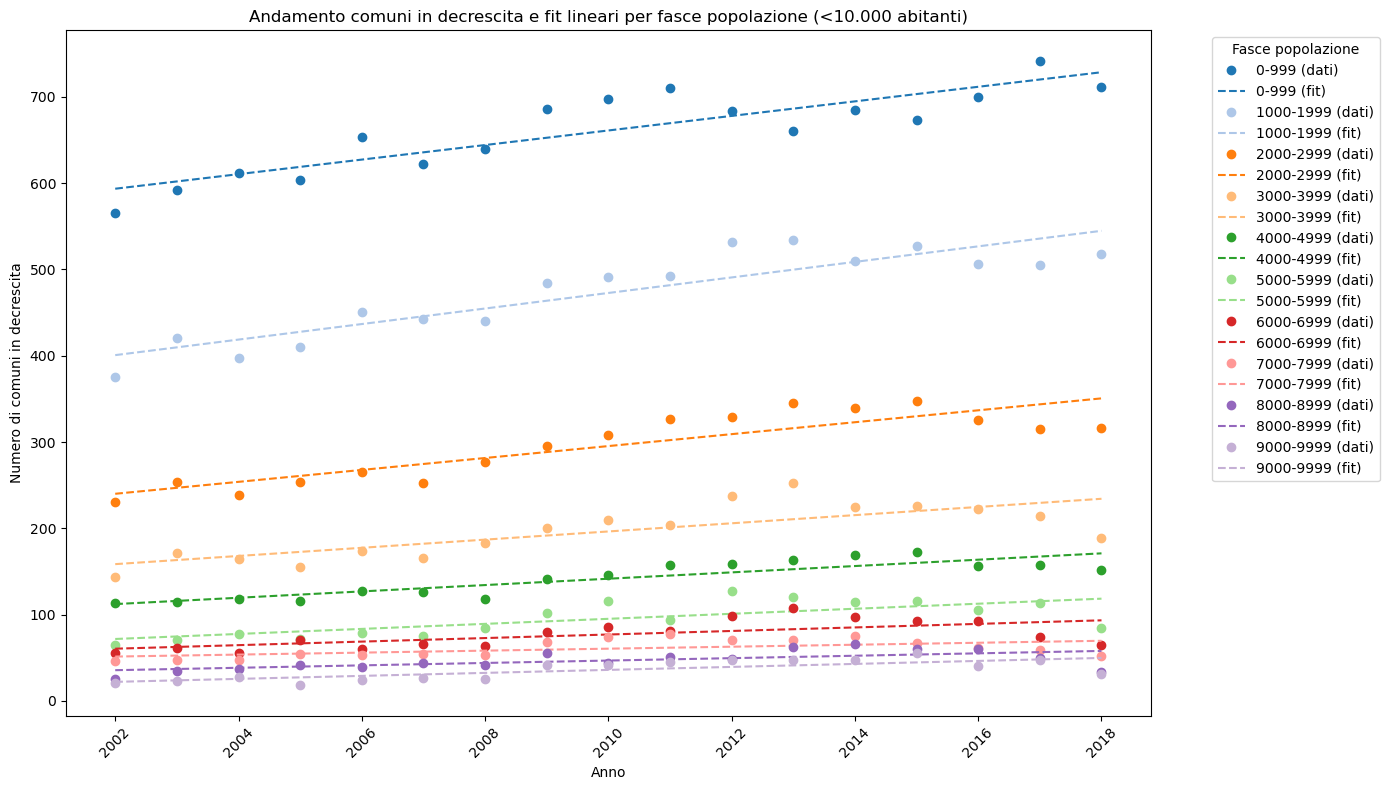

In [26]:
# Visualizzazione con fit lineare per ciascuna fascia di popolazione
plt.figure(figsize=(14, 8))
x = decrescita_time.index.astype(int).values
colors = plt.cm.tab20.colors  # palette di colori distinti

print("Parametri del fit lineare per ciascuna fascia (coeff. angolare, intercetta):")
for i, fascia in enumerate(labels):
    y = decrescita_time[fascia].values
    color = colors[i % len(colors)]
    # Fit lineare
    coeffs = np.polyfit(x, y, deg=1)
    p = np.poly1d(coeffs)
    y_fit = p(x)
    # Stampa parametri del fit
    slope, intercept = coeffs
    print(f"{fascia}: coeff. angolare = {slope:.3f}, intercetta = {intercept:.3f}")
    
    # Plot punti dati
    plt.plot(x, y, marker='o', linestyle='none', color=color, label=f'{fascia} (dati)')
    # Plot linea di fit lineare tratteggiata
    plt.plot(x, y_fit, linestyle='--', color=color, label=f'{fascia} (fit)')

plt.xticks(rotation=45)
plt.xlabel('Anno')
plt.ylabel('Numero di comuni in decrescita')
plt.title('Andamento comuni in decrescita e fit lineari per fasce popolazione (<10.000 abitanti)')
plt.legend(title='Fasce popolazione', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Lista anni dal 2002 in poi, escludendo il 2019
anni = [col for col in inData_Residenti_NoTot.columns if str(col).isdigit() and int(col) >= 2002 and col != '2019']

# Definisci fasce da 0 a 10000 abitanti con step 1000
bins = np.arange(0, 10000 + 1000, 1000)
labels = [f'{bins[i]}-{bins[i+1]-1}' for i in range(len(bins)-1)]

# DataFrame per risultati (anni come indice, fasce come colonne)
crescita_time = pd.DataFrame(index=anni, columns=labels)

for anno in anni:
    popolazione_anno = inData_Residenti_NoTot.set_index('Territorio')[anno].astype(float)
    tasso_crescita_anno = tasso_crescita_netto[anno]
    df = pd.DataFrame({
        'popolazione': popolazione_anno,
        'tasso_crescita': tasso_crescita_anno
    })
    # Filtra comuni con popolazione < 10000
    df_small = df[df['popolazione'] < 10000].copy()
    # Assegna fascia di popolazione
    df_small['pop_bin'] = pd.cut(df_small['popolazione'], bins=bins, labels=labels, right=False)
    # Seleziona comuni con tasso di crescita positivo
    df_crescita = df_small[df_small['tasso_crescita'] > 0]
    # Conta comuni per fascia
    counts = df_crescita.groupby('pop_bin', observed=True).size()
    # Riempie NaN con 0 e assegna al DataFrame
    crescita_time.loc[anno] = counts.reindex(labels, fill_value=0)

# Converti valori a interi
crescita_time = crescita_time.astype(int)




Parametri del fit lineare per ciascuna fascia (coeff. angolare, intercetta):
0-999: coeff. angolare = -10.571, intercetta = 21874.632
1000-1999: coeff. angolare = -14.262, intercetta = 29151.015
2000-2999: coeff. angolare = -8.417, intercetta = 17243.500
3000-3999: coeff. angolare = -4.995, intercetta = 10269.676
4000-4999: coeff. angolare = -4.498, intercetta = 9219.662
5000-5999: coeff. angolare = -3.441, intercetta = 7051.647
6000-6999: coeff. angolare = -0.993, intercetta = 2106.574
7000-7999: coeff. angolare = -1.483, intercetta = 3076.868
8000-8999: coeff. angolare = -1.113, intercetta = 2322.029
9000-9999: coeff. angolare = -0.490, intercetta = 1045.647


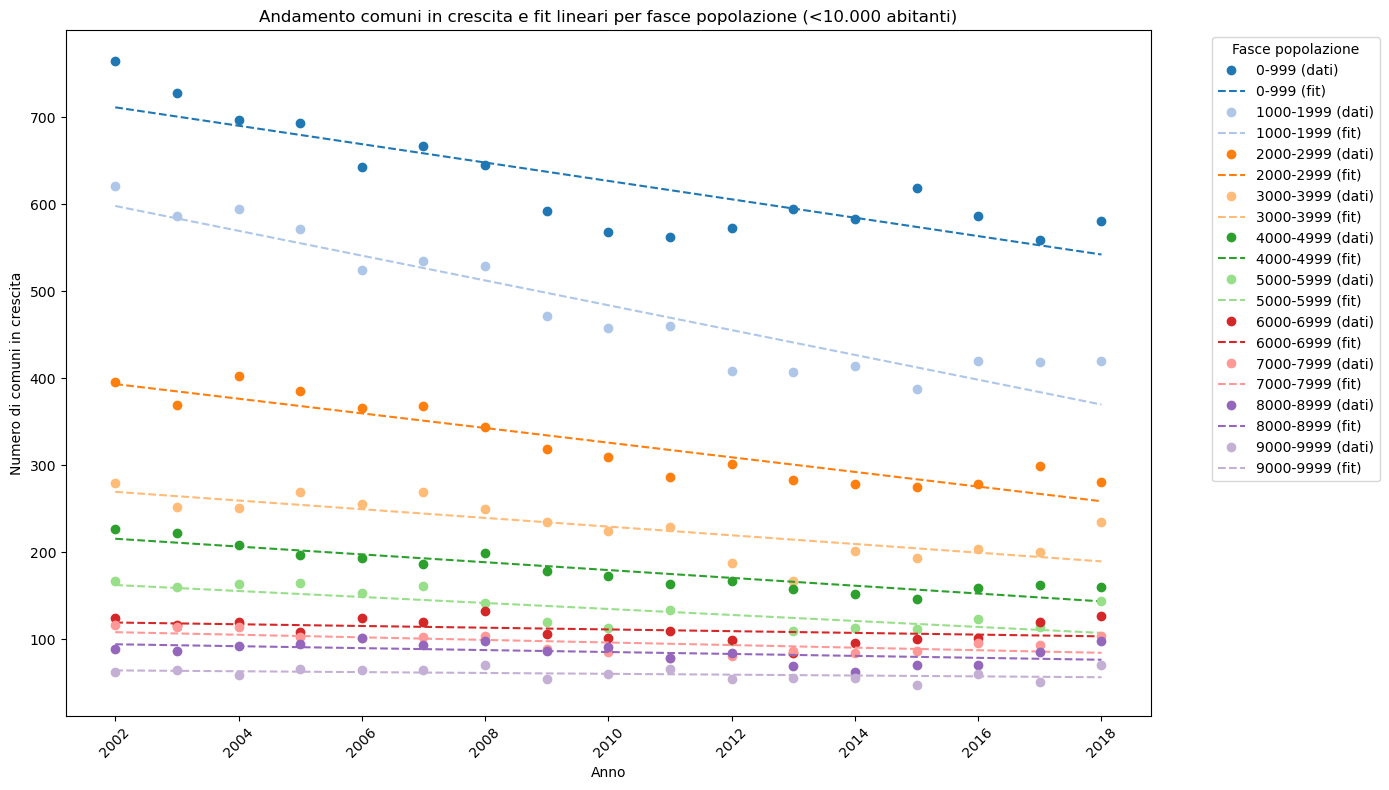

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# Visualizzazione con fit lineare per ciascuna fascia di popolazione (comuni in crescita)
plt.figure(figsize=(14, 8))
x = crescita_time.index.astype(int).values
colors = plt.cm.tab20.colors  # palette colori distinti

print("Parametri del fit lineare per ciascuna fascia (coeff. angolare, intercetta):")
for i, fascia in enumerate(labels):
    y = crescita_time[fascia].values.astype(float)
    color = colors[i % len(colors)]
    
    # Fit lineare
    coeffs = np.polyfit(x, y, deg=1)
    p = np.poly1d(coeffs)
    y_fit = p(x)
    
    # Stampa parametri
    slope, intercept = coeffs
    print(f"{fascia}: coeff. angolare = {slope:.3f}, intercetta = {intercept:.3f}")
    
    # Plot punti dati
    plt.plot(x, y, marker='o', linestyle='none', color=color, label=f'{fascia} (dati)')
    # Plot linea di fit lineare tratteggiata
    plt.plot(x, y_fit, linestyle='--', color=color, label=f'{fascia} (fit)')

plt.xticks(rotation=45)
plt.xlabel('Anno')
plt.ylabel('Numero di comuni in crescita')
plt.title('Andamento comuni in crescita e fit lineari per fasce popolazione (<10.000 abitanti)')
plt.legend(title='Fasce popolazione', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


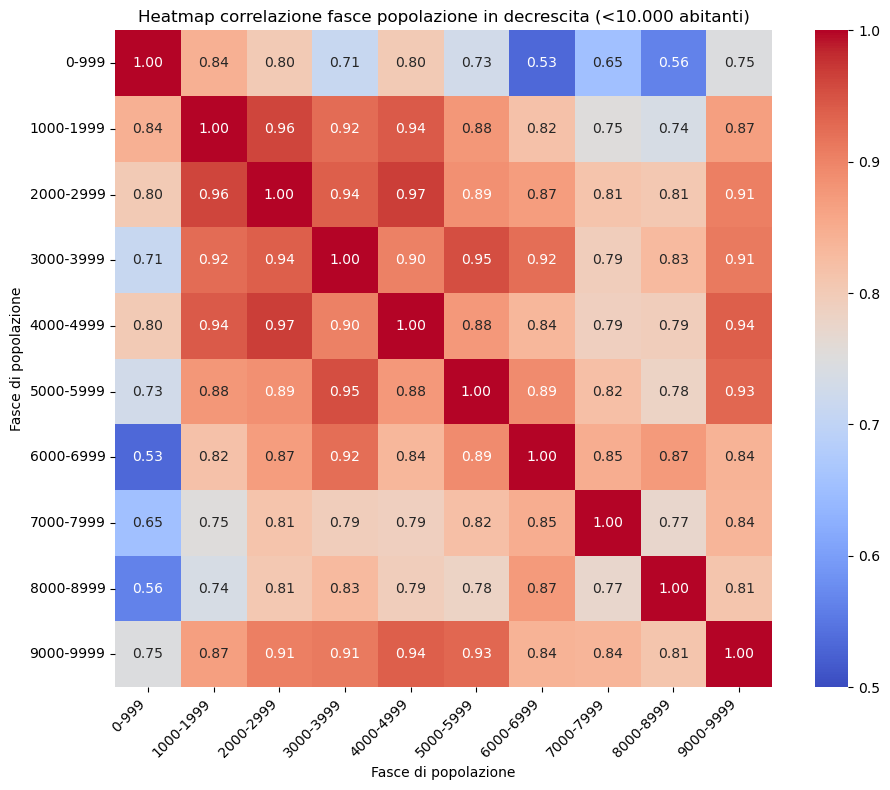

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Lista anni dal 2002 in poi, escluso 2019
anni = [col for col in inData_Residenti_NoTot.columns if str(col).isdigit() and int(col) >= 2002 and col != '2019']

# Definisci fasce di popolazione da 0 a 10000 step 1000
bins = np.arange(0, 10000 + 1000, 1000)
labels = [f'{bins[i]}-{bins[i+1]-1}' for i in range(len(bins)-1)]

# DataFrame per contenere i conteggi per fascia di popolazione e anno
decrescita_time_10k = pd.DataFrame(index=anni, columns=labels)

for anno in anni:
    popolazione_anno = inData_Residenti_NoTot.set_index('Territorio')[anno].astype(float)
    tasso_crescita_anno = tasso_crescita_netto[anno]
    df = pd.DataFrame({
        'popolazione': popolazione_anno,
        'tasso_crescita': tasso_crescita_anno
    })
    # Filtra i comuni con popolazione < 10000
    df_small = df[df['popolazione'] < 10000].copy()
    # Assegna fasce di popolazione
    df_small['pop_bin'] = pd.cut(df_small['popolazione'], bins=bins, labels=labels, right=False)
    # Seleziona solo comuni in decrescita
    df_decrescita = df_small[df_small['tasso_crescita'] < 0]
    # Conta comuni per fascia
    counts = df_decrescita.groupby('pop_bin', observed=True).size()
    # Popola DataFrame riempiendo valori mancanti con 0
    decrescita_time_10k.loc[anno] = counts.reindex(labels, fill_value=0)

# Converte valori a interi
decrescita_time_10k = decrescita_time_10k.astype(int)

# Calcola matrice di correlazione
correlation_matrix = decrescita_time_10k.corr()

# Visualizza la heatmap senza bordi, con colormap coolwarm e scala da 0.5 a 1
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True,
            square=True, linewidths=0, linecolor='gray', vmin=0.5, vmax=1)
plt.title('Heatmap correlazione fasce popolazione in decrescita (<10.000 abitanti)')
plt.xlabel('Fasce di popolazione')
plt.ylabel('Fasce di popolazione')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
